In [1]:
import particles
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import mcmc
from particles import smc_samplers as ssp
from particles.collectors import Moments

# Read data

In [2]:
# read the datafile
data = pd.read_csv("data.csv")
print(data.shape)

# pull out the relevant columns as np arrays
price = np.array(data.sp500_price)
zero_risk = np.array(data.zr_yield)
div_yield = np.array(data.sp500_yield)

# returns is log of daily price increase
returns = np.log(price[1:] / price[:-1])
# need to normalize these from yearly to daily rate
# but, the sp500 is only open on weekdays
# and there are about 252 weekdays in a year
r = np.log(zero_risk[:-1]) / 252
delta = np.log(div_yield[:-1]) / 252

(5000, 6)


# Parameters

In [3]:
# Parameters for SV, SVJR, SVJV, SVCJ models

# speed of mean reversion
kappa = None
# unconditional mean variance
theta = None
# variance of variance
sigma = None
# corr between Brownian motions
rho = None
# diffusive equity risk premium (linear in Vt)
eta_s = None
# diffusive variance risk premium
eta_v = None

# jump intensity for Poisson process
lbda = None
# mean of the return jump size
mu_s = None
# standard deviation of the return jump size
sigma_s = None
# mean jump sizes of return
eta_J_s = None
# params of Exp()
mu_v = None
# mean jump sizes of variance
eta_J_v = None
# correlation
rho_J = None
#
sigma_c = None

# Others

# risk-free rate
rt = None
# dividend yield
delta_t = None
# index level
St = None

# Heston model

In [4]:
default_heston_params = {
    "kappa": 1.0,
    "theta": 0.0,
    "sigma": 1.0,
    "rho": -1.0,
    "eta_s": 1.0,
}

class HestonVol(ssm.StateSpaceModel):
    """
    SV Model of Heston
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.r = r
        self.delta = delta

    def PX0(self):
        V_prev_dist = dists.Dirac(loc=self.theta)
        W = dists.Normal()

        return dists.IndepProd(V_prev_dist, W)

    def PX(self, t, xp): # Distribution of X_t given X_{t-1}=xp (p=past)
        # the hidden state is NOT (V_t, w_t, B_t)!
        # rather, it is           (V_{t-1}, ...)
        V_prev, W_prev = xp.T

        # Compute V_{t-1}
        V = (
            V_prev
            + self.kappa * (self.theta - V_prev)
            + self.sigma * np.sqrt(V_prev) * W_prev
        )
        # keep it above zero
        # if 2 kappa theta > sigma^2, then the *continous* process stays positive.
        # but the discretized process can still end up negative.
        V = np.maximum(V, 0)

        # rather than calculate the distribution for V_t, we'll compute V_{t-1} and save that
        # and V_t can be computed on the next iteration, after drawing from the distributions for
        V_dist = dists.Dirac(loc=V)

        # all of these distributions are constant and independant
        W = dists.Normal()

        return dists.IndepProd(V_dist, W)

    def PY(self, t, xp, x): # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        # we don't need xp: x contains (V_{t_1}, w_t, B_t, etc.)
        V_prev, W = x.T

        # data has to be aligned correctly...
        mu = (
            self.r[t]
            - self.delta[t]
            + V_prev * (self.eta_s - 0.5)
        )
        # R_{t+1} = mu + sqrt(v_t) z
        # where z and w are N(0, 1) with correlation rho
        # hence z|w ~ N(rho * w, (1 - rho^2))
        # and so R|(w, v) ~ N(mu + sqrt(v) rho w, v_t (1 - rho^2))
        # distributions package expect sigma, not sigma^2
        sqv = np.sqrt(V_prev)
        return dists.Normal(
            loc=mu + sqv * self.rho * W, scale=sqv * np.sqrt(1 - self.rho**2)
        )

heston_theta = {
    "kappa": 7.4 / 252,
    "theta": 0.02,
    "sigma": 0.4 / np.sqrt(252),
    "rho": -0.82,
    "eta_s": 3.25 / 252,
}

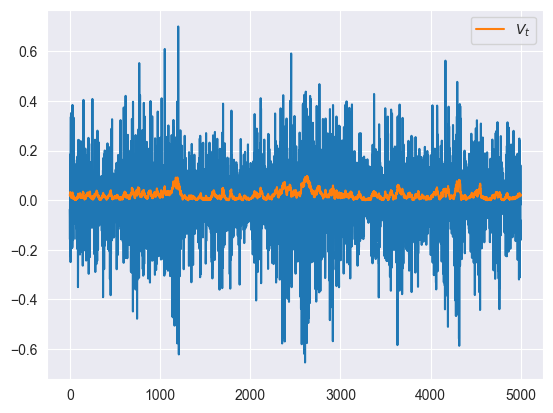

In [5]:
heston_model = HestonVol(**heston_theta)

# 4999 is the maximum value that we can simulate due to r and delta params
heston_states, heston_data = heston_model.simulate(4999)

heston_states = np.asarray(heston_states).squeeze()

plt.figure()
plt.plot(heston_data)
plt.plot(heston_states[:, 0], label="$V_t$")
plt.legend()
plt.show()

# Bootstrap filter

In [6]:
fk_model = ssm.Bootstrap(ssm=heston_model, data=heston_data)

# PMMH

In [15]:
# not sure about which prior to use for each params
heston_dict = {
    "kappa": dists.Normal(),
    "theta": dists.Normal(),
    "sigma": dists.Gamma(a=1., b=1.),
    "rho": dists.Beta(9., 1.),
    "eta_s": dists.Normal(),
}
heston_prior = dists.StructDist(heston_dict)

# give a theta0 or it will sample from heston_prior
theta0 = np.array(
    [tuple([v for v in default_heston_params.values()])],
    dtype=[("kappa", "f8"), ("theta", "f8"), ("sigma", "f8"), ("rho", "f8"), ("eta_s", "f8")]
)

heston_pmmh = mcmc.PMMH(ssm_cls=HestonVol, prior=heston_prior, data=heston_data, Nx=1000, niter=30)
heston_pmmh.run()

/Users/guillaumephilippe/experiments/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


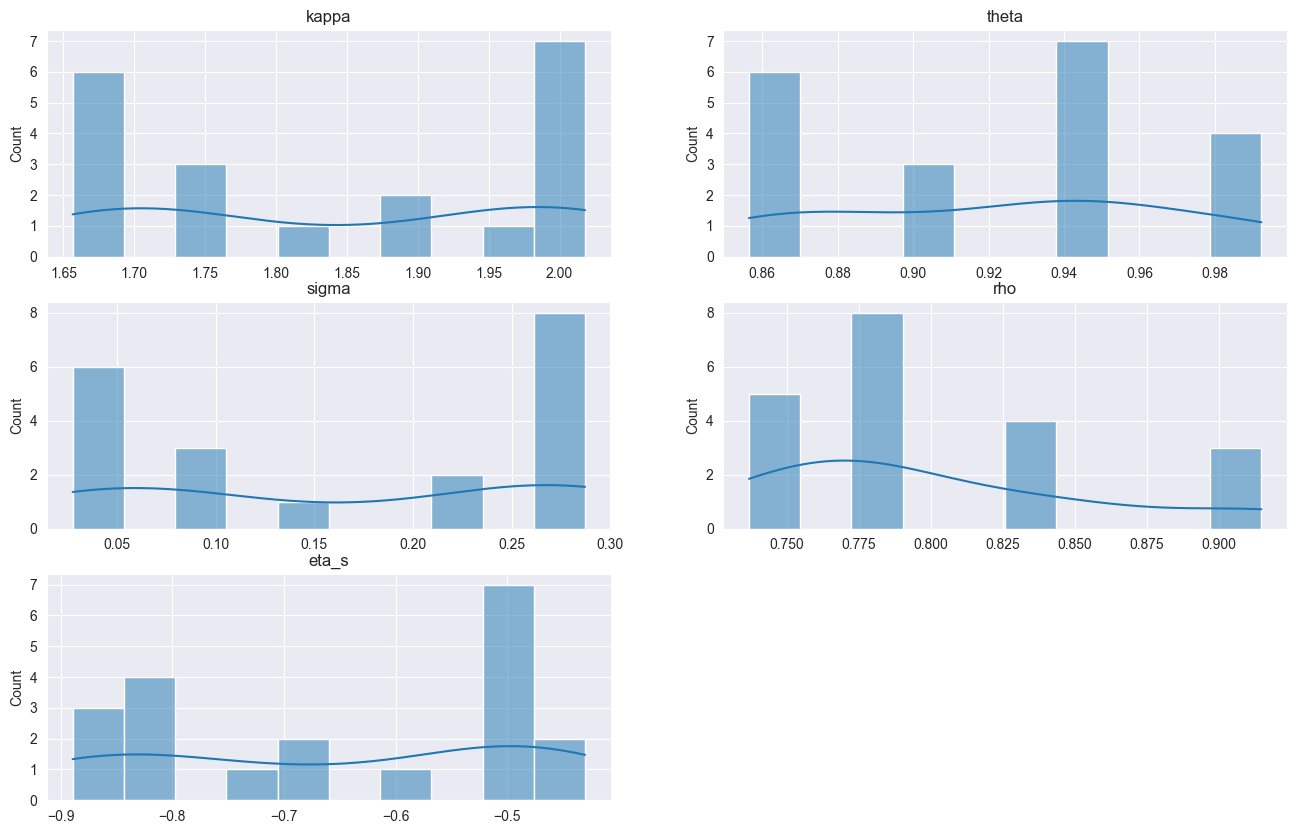

In [16]:
burnin = 10
plt.figure(figsize=(16,10))
for i, param in enumerate(heston_dict.keys()):
    plt.subplot(3, 2, i+1)
    sns.histplot(heston_pmmh.chain.theta[param][burnin:], bins=10, kde=True)
    plt.title(param)
plt.show()

In [9]:
class SVJR(ssm.StateSpaceModel):
    """
    Model with return jumps
    """

    def PX0(self):
        return

    def PX(self, t, xp):
        return

    def PY(self, t, xp, x):
        return

In [10]:
class SVJV(ssm.StateSpaceModel):
    """
    Model with variance jumps
    """

    def PX0(self):
        return

    def PX(self, t, xp):
        return

    def PY(self, t, xp, x):
        return

In [11]:
class SVCJ(ssm.StateSpaceModel):
    """
    Model with correlated return and variance jumps.
    Parameters:
    r: risk-free yield, data
    delta: dividend yield, data
    index: index level, data

    kappa: speed of mean reversion
    """

    default_params = {
        "kappa": 1.0,
        "theta": 0.0,
        "sigma": 1.0,
        "rho": -1.0,
        "eta_s": 1.0,
        "lam": 0.5,
        "mu_s": 0.0,
        "sigma_s": 1.0,
        "mu_v": 0.0,
        "rho_j": 0.0,
    }

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mubar_s = (
            np.exp(self.mu_s + self.sigma_s**2 / 2) / (1 - self.rho_j * self.mu_v) - 1
        )

    def PX0(self):
        V_prev_dist = dists.Dirac(loc=self.theta)
        w = dists.Normal()
        B = dists.Binomial(n=1, p=self.lam)
        # This gives an exponential distribution
        Jv = dists.Gamma(a=1, b=self.mu_v)
        Js_minus_rho_jv = dists.Normal(loc=self.mu_s, scale=self.sigma_s)

        return dists.IndepProd(V_prev_dist, w, B, Jv, Js_minus_rho_jv)

    def PX(self, t, xp):
        # the hidden state is NOT (V_t, w_t, B_t, Jv_t, Js_t)!
        # rather, it is           (V_{t-1}, ...)
        (V_prev_prev, w_prev, B_prev, Jv_prev, Js_minus_rho_jv_prev) = xp.T

        # Compute V_{t-1}
        V_prev = (
            V_prev_prev
            + self.kappa * (self.theta - V_prev_prev)
            + self.sigma * np.sqrt(V_prev_prev) * w_prev
            + Jv_prev * B_prev
        )
        # keep it above zero
        # if 2 kappa theta > sigma^2, then the *continous* process stays positive.
        # but the discretized process can still end up negative.
        V_prev = np.maximum(V_prev, 0)

        # rather than calculate the distribution for V_t, we'll compute V_{t-1} and save that
        # and V_t can be computed on the next iteration, after drawing from the distributions for
        V_prev_dist = dists.Dirac(loc=V_prev)

        # all of these distributions are constant and independant
        w = dists.Normal()
        B = dists.Binomial(n=1, p=self.lam)
        # This gives an exponential distribution
        Jv = dists.Gamma(a=1, b=self.mu_v)
        Js_minus_rho_jv = dists.Normal(loc=self.mu_s, scale=self.sigma_s)

        return dists.IndepProd(V_prev_dist, w, B, Jv, Js_minus_rho_jv)

    def PY(self, t, xp, x):
        # we don't need xp: x contains (V_{t_1}, w_t, B_t, etc.)
        (V_prev, w, B, Jv, Js_minus_rho_jv) = x.T
        Js = Js_minus_rho_jv + self.rho_j * Jv

        # data has to be aligned correctly...
        mu = (
            self.r[t]
            - self.delta[t]
            - self.lam * self.mubar_s
            + V_prev * (self.eta_s - 0.5)
            + Js * B
        )
        # R_{t+1} = mu + sqrt(v_t) z
        # where z and w are N(0, 1) with correlation rho
        # hence z|w ~ N(rho * w, (1 - rho^2))
        # and so R|(w, v) ~ N(mu + sqrt(v) rho w, v_t (1 - rho^2))
        # distributions package expect sigma, not sigma^2
        sqv = np.sqrt(V_prev)
        return dists.Normal(
            loc=mu + sqv * self.rho * w, scale=sqv * np.sqrt(1 - self.rho**2)
        )

In [12]:
# now we'll try initializing a SVCJ, using the parameters obtained in the paper
# based on data only from returns (Table A1)

# they say "parameters are annualized? what does this mean..."
# I think this means that in the original differential equation, one unit of time is equal to a year.
# In the discretization, some parameters need to be scaled.

# I'm also especially unsure about lambda. It's the probability for a Bernoulli,
# which represents the discretization a Poisson point process with rate lambda...
params_article = {
    "kappa": 7.4 / 252,
    "theta": 0.02,
    "sigma": 0.4 / np.sqrt(252),
    "rho": -0.82,
    "eta_s": 3.25 / 252,
    "lam": 0.8 / 252,
    "mu_s": -0.02,
    "sigma_s": 0.02 / np.sqrt(252),
    "mu_v": 0.08 * 252,
    "rho_j": -0.09,
}

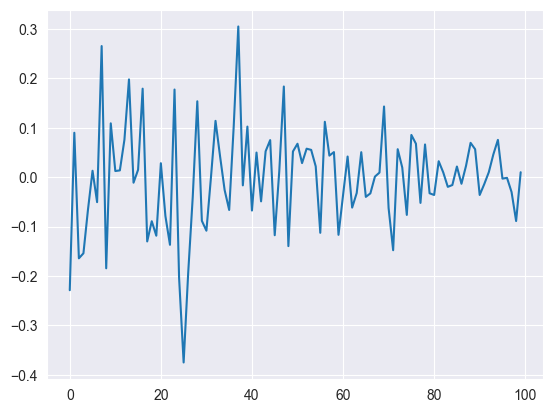

In [13]:
SVCJ_a1 = SVCJ(r=r, delta=delta, **params_article)

true_states, data = SVCJ_a1.simulate(100)

plt.figure()
plt.plot(data)
plt.show()

# Orthogonal MCMC

# SMC^2

In [14]:
ssp.SMC2()